In [1]:
import pandas as pd
from pairsbacktester import PairsBacktester
from utils import plot, get_regression_model, passes_adfuller_test

In [2]:
# Loading the training data (2017 to 2022)
DATA = pd.read_csv('./data/closing_prices.csv').set_index('Date')

In [3]:
# Get the list of stock tickers
TICKERS = DATA.columns
TICKERS

Index(['ADANIENT', 'ADANIPORTS', 'APOLLOHOSP', 'ASIANPAINT', 'AXISBANK',
       'BAJAJ-AUTO', 'BAJFINANCE', 'BAJAJFINSV', 'BEL', 'BPCL', 'BHARTIARTL',
       'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GRASIM',
       'HCLTECH', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M',
       'MARUTI', 'NTPC', 'NESTLEIND', 'ONGC', 'POWERGRID', 'RELIANCE',
       'SHRIRAMFIN', 'SBIN', 'SUNPHARMA', 'TCS', 'TATACONSUM', 'TATAMOTORS',
       'TATASTEEL', 'TECHM', 'TITAN', 'TRENT', 'ULTRACEMCO', 'WIPRO'],
      dtype='object')

In [4]:
# Split training data (2017 to 2022) from the corpus

TRAINING_DATA = DATA[:'2023-01-01']
TESTING_DATA = DATA['2023-01-01':]


In [5]:
# Store all the cointegrated pairs in this list
COINT_PAIRS = []

for first_ticker in range(len(TICKERS) - 1):
    for second_ticker in range(first_ticker + 1, len(TICKERS)):

        ticker1 = TICKERS[first_ticker]
        ticker2 = TICKERS[second_ticker]

        data1 = TRAINING_DATA[ticker1]
        data2 = TRAINING_DATA[ticker2]

        # Retrieve model 
        model = get_regression_model(data1, data2)

        # Get residuals to test for stationarity
        residuals = model.resid

        # Gauge cointegration by performing the AdFuller test with a confidence level of 99%
        if passes_adfuller_test(residuals, alpha=0.01):
            # If test passes then add the pair to the list
            print (f'Pair ({ticker1}, {ticker2}) is cointegrated (99% confidence)')
            COINT_PAIRS.append({
                'pair': str((ticker1, ticker2)),
                'ticker1': ticker1,
                'ticker2': ticker2,
                'model': model
            })


Pair (ADANIPORTS, APOLLOHOSP) is cointegrated (99% confidence)
Pair (ADANIPORTS, BAJAJ-AUTO) is cointegrated (99% confidence)
Pair (ADANIPORTS, CIPLA) is cointegrated (99% confidence)
Pair (ADANIPORTS, JSWSTEEL) is cointegrated (99% confidence)
Pair (ADANIPORTS, ULTRACEMCO) is cointegrated (99% confidence)
Pair (APOLLOHOSP, ASIANPAINT) is cointegrated (99% confidence)
Pair (APOLLOHOSP, BAJAJFINSV) is cointegrated (99% confidence)
Pair (APOLLOHOSP, HCLTECH) is cointegrated (99% confidence)
Pair (APOLLOHOSP, HDFCBANK) is cointegrated (99% confidence)
Pair (APOLLOHOSP, INFY) is cointegrated (99% confidence)
Pair (APOLLOHOSP, TITAN) is cointegrated (99% confidence)
Pair (APOLLOHOSP, ULTRACEMCO) is cointegrated (99% confidence)
Pair (ASIANPAINT, BAJFINANCE) is cointegrated (99% confidence)
Pair (ASIANPAINT, HCLTECH) is cointegrated (99% confidence)
Pair (ASIANPAINT, HDFCBANK) is cointegrated (99% confidence)
Pair (ASIANPAINT, INFY) is cointegrated (99% confidence)
Pair (ASIANPAINT, KOTAKBAN

In [6]:
ALL_TRADES = pd.DataFrame()
PAIRWISE_BACKTESTING_INSTANCE = {}

# Iterate throught all coint pairs, backtest them, save their trades and backtesting instance (will need it later for plotting)
for pair in COINT_PAIRS:
    pair_bb = PairsBacktester(
        TESTING_DATA,
        pair['ticker1'],
        pair['ticker2'],
        pair['model']
    )
    pair_bb.trade()
    pair_bb.calculate_trade_statistics(equal_wts=True)
    PAIRWISE_BACKTESTING_INSTANCE[f'{str((pair["ticker1"], pair["ticker2"]))}'] = pair_bb
    ALL_TRADES = pd.concat([ALL_TRADES, pair_bb.trades])


In [7]:
# Analyze all the trades by pairs

results = ALL_TRADES.groupby('pair').agg(
    count_total_trades=('residual_state', 'count'),
    mean_trade_duration_days=('duration', 'mean'),
    mean_profit_perc_per_trade=('net_perc', 'mean') ,
    total_profit_perc=('net_perc', 'sum')
)

In [8]:
results.sort_values(by='total_profit_perc', ascending=False)

,count_total_trades,mean_trade_duration_days,mean_profit_perc_per_trade,total_profit_perc
pair,,,,
"(ADANIPORTS, CIPLA)",3,91.666667,0.080488,0.241465
"(ADANIPORTS, APOLLOHOSP)",1,312.000000,0.191164,0.191164
"(POWERGRID, SUNPHARMA)",4,50.750000,0.046914,0.187657
"(ASIANPAINT, BAJFINANCE)",4,41.750000,0.044972,0.179887
"(POWERGRID, SBIN)",3,53.666667,0.055732,0.167195
"(GRASIM, HINDALCO)",2,150.000000,0.081539,0.163079
"(APOLLOHOSP, HCLTECH)",3,48.000000,0.053178,0.159535
"(HDFCBANK, TCS)",2,158.500000,0.060401,0.120803
"(ICICIBANK, TITAN)",3,24.333333,0.034651,0.103952


In [9]:
# Analyze a certain pair

pair_to_analyse = ('ASIANPAINT', 'BAJFINANCE')
backtesting_class = PAIRWISE_BACKTESTING_INSTANCE[str(pair_to_analyse)]

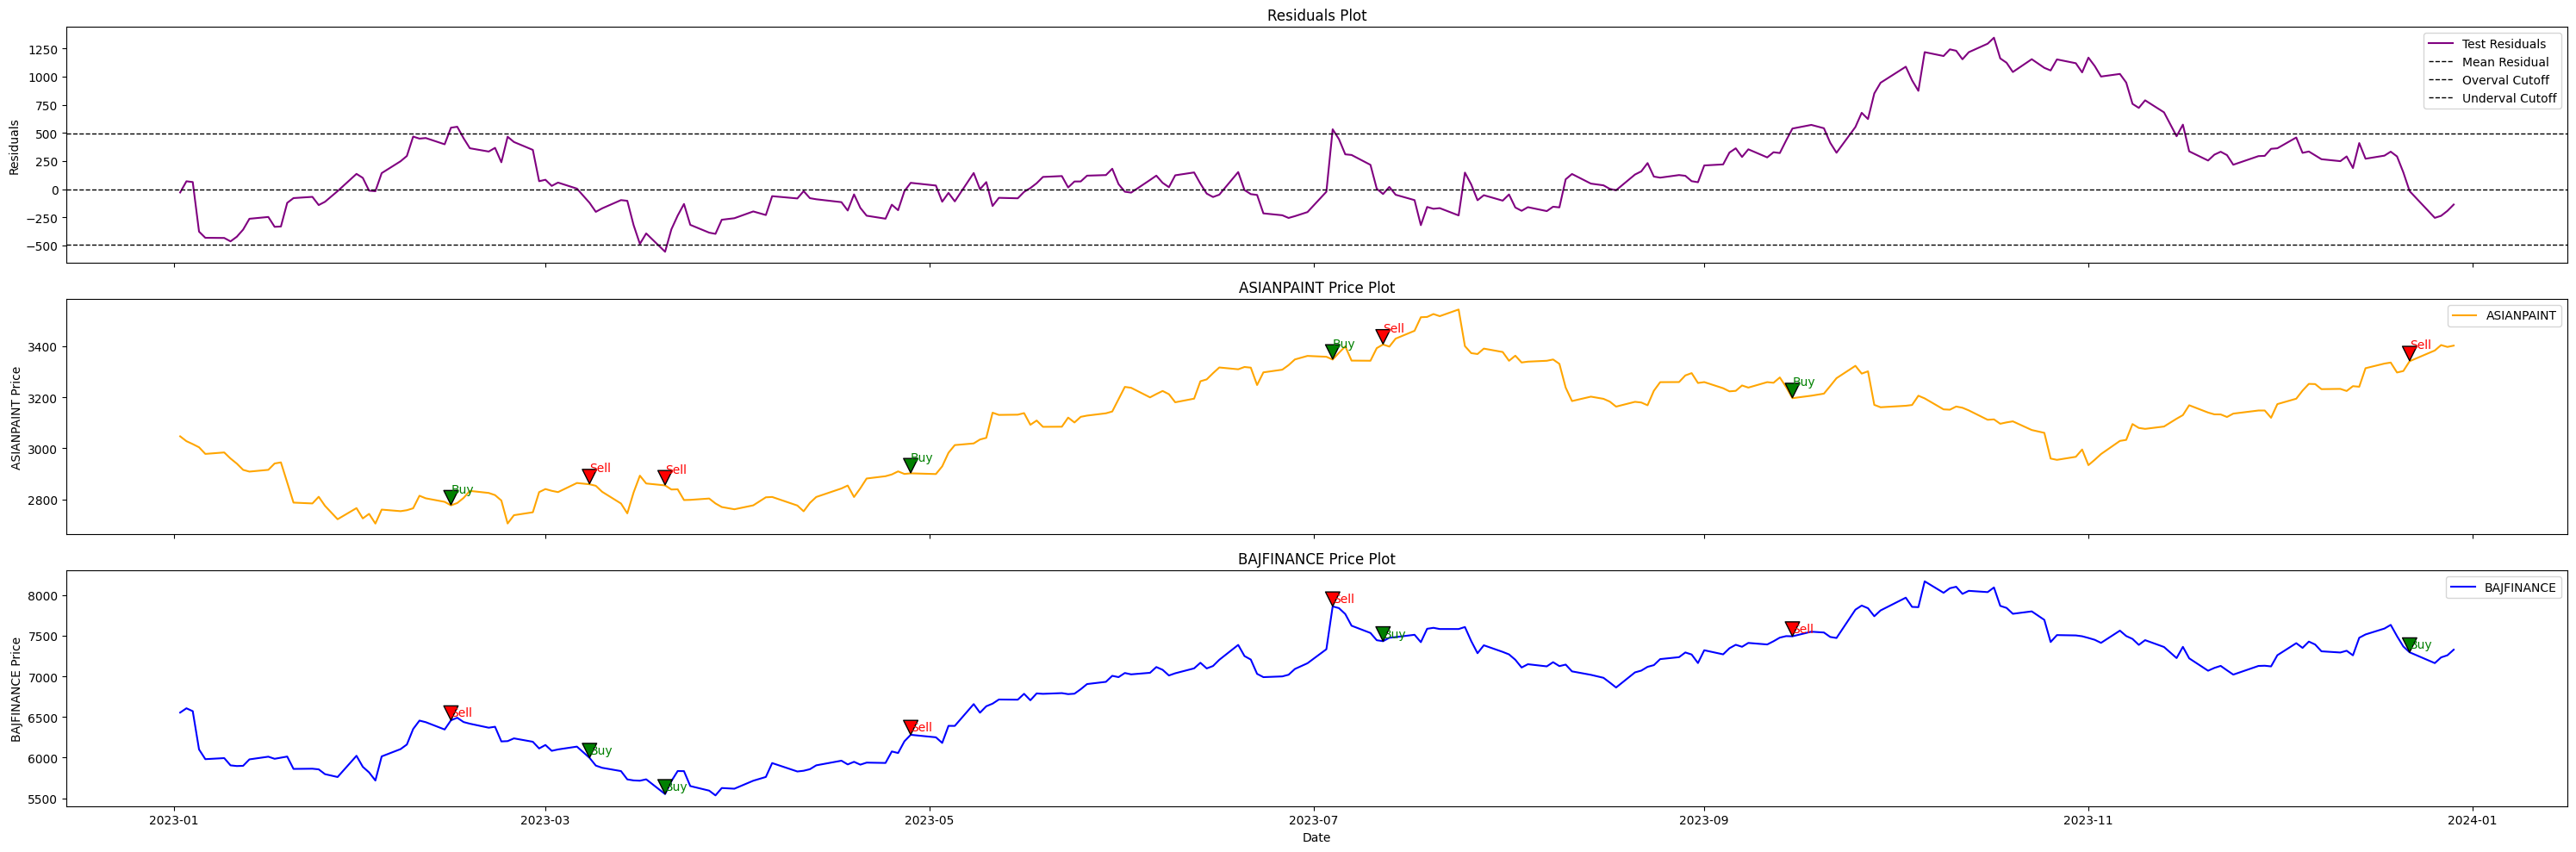

In [10]:
plot(
    t=backtesting_class.testing_data,
    ticker1=backtesting_class.ticker1,
    ticker2=backtesting_class.ticker2,
    res_mean=backtesting_class.residuals_mean,
    overval_cutoff=backtesting_class.res_overval_cutoff,
    underval_cutoff=backtesting_class.res_underval_cutoff
)